# Strategy Horizontal Comparison
This is for all strategy to horizontal comparison, and with same input and same assets

2024-07-22 17:46:08,641 - INFO - start load files from 2023-08-13 to 2023-08-16...
2024-07-22 17:46:08,718 - INFO - load file complete, preparing...
2024-07-22 17:46:08,985 - INFO - data has been prepared
2024-07-22 17:46:09,014 - INFO - init strategy...
2024-07-22 17:46:09,018 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1912.37it/s]
2024-07-22 17:46:12,037 - INFO - main loop finished
2024-07-22 17:46:12,242 - INFO - Print actuator summary
2024-07-22 17:46:12,426 - INFO - Backtesting finished, execute time 3.4125750064849854s


Final account status                              
Token balance in broker       
USDC      :1800                     ETH       :1                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
Empty DataFrame


Account balance history                           
l1                  net_value tokens     uni_market                                                                                          price     
l2                              USDC ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 3648.1243   1800   1          0                0                 0                0                 0              0 1848.1244    1
2023-08-13 00:01:00 3648.1243   1800   1          0                0                 0                0     

2024-07-22 17:46:12,504 - INFO - files have saved to ./result\backtest-20240722-174612.account.csv,./result\backtest-20240722-174612.action.json,./result\backtest-20240722-174612.action.pkl
C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


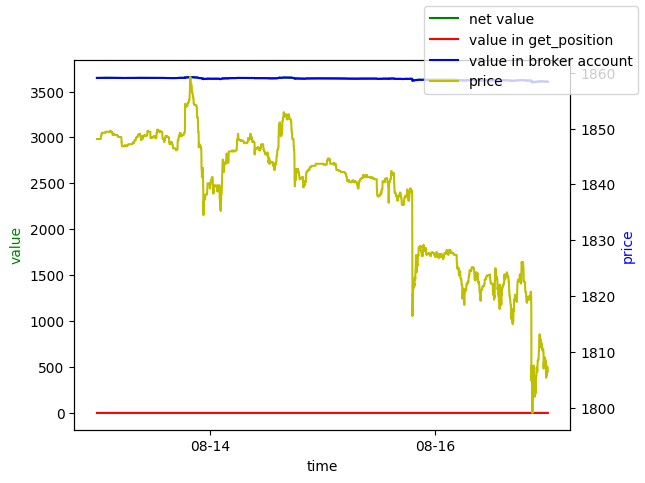

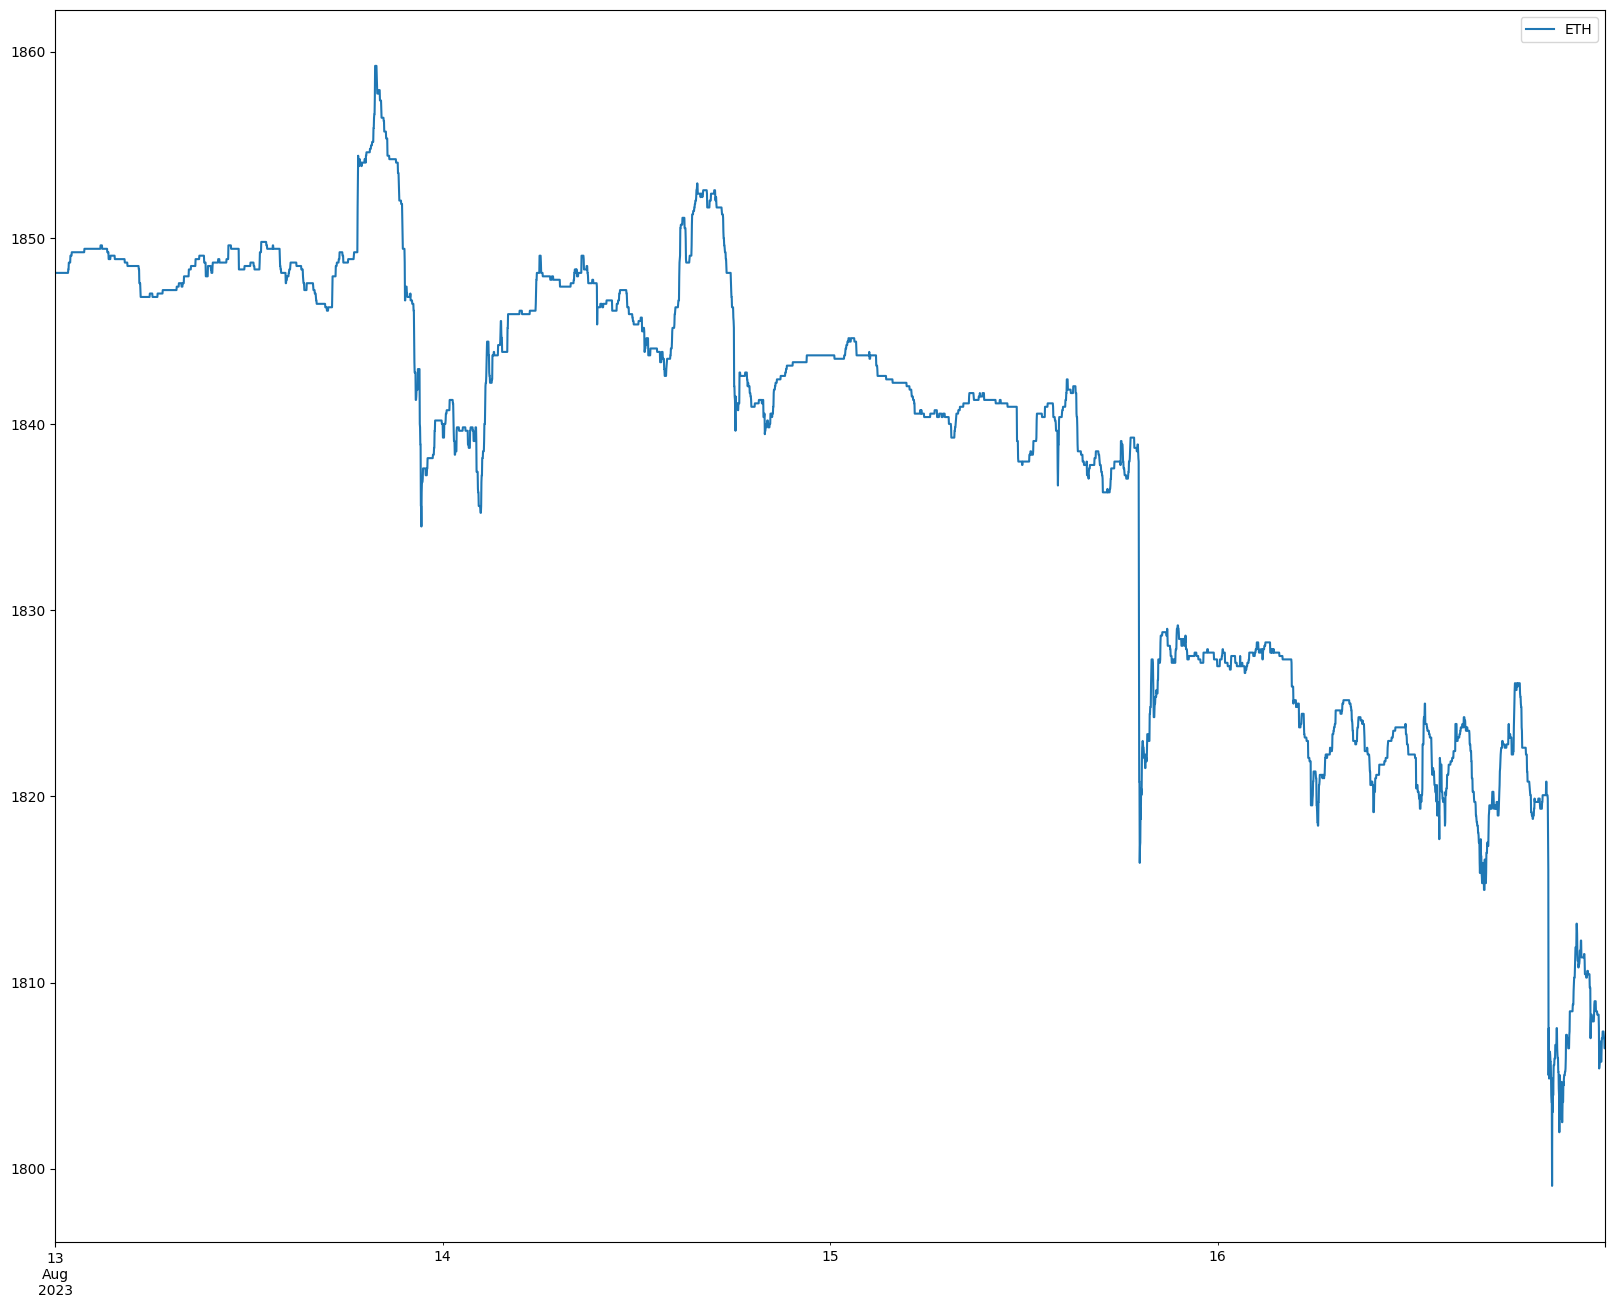

2024-07-22 17:46:13,804 - INFO - init strategy...
2024-07-22 17:46:13,827 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1483.75it/s]
2024-07-22 17:46:17,713 - INFO - main loop finished
2024-07-22 17:46:17,838 - INFO - Print actuator summary
2024-07-22 17:46:17,998 - INFO - Backtesting finished, execute time 4.197205305099487s


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.026039577              
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick     pending0        pending1       liquidity
0     -887272      887272  0.079874931  0.000050831990  41870380470367

Account balance history                           
l1                  net_value tokens             uni_market                                                                                          price     
l2                              USDC         ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 3648.1245      0 0.026039578       3600    9.3383905e-09                 0        0.9739604        

2024-07-22 17:46:18,069 - INFO - files have saved to ./result\backtest-20240722-174617.account.csv,./result\backtest-20240722-174617.action.json,./result\backtest-20240722-174617.action.pkl
C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


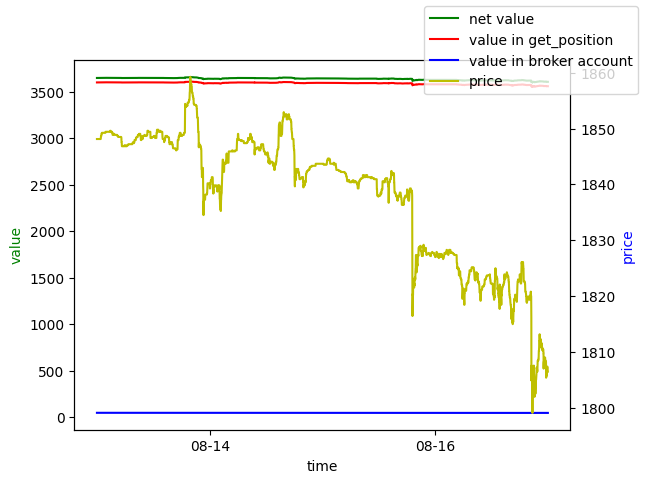

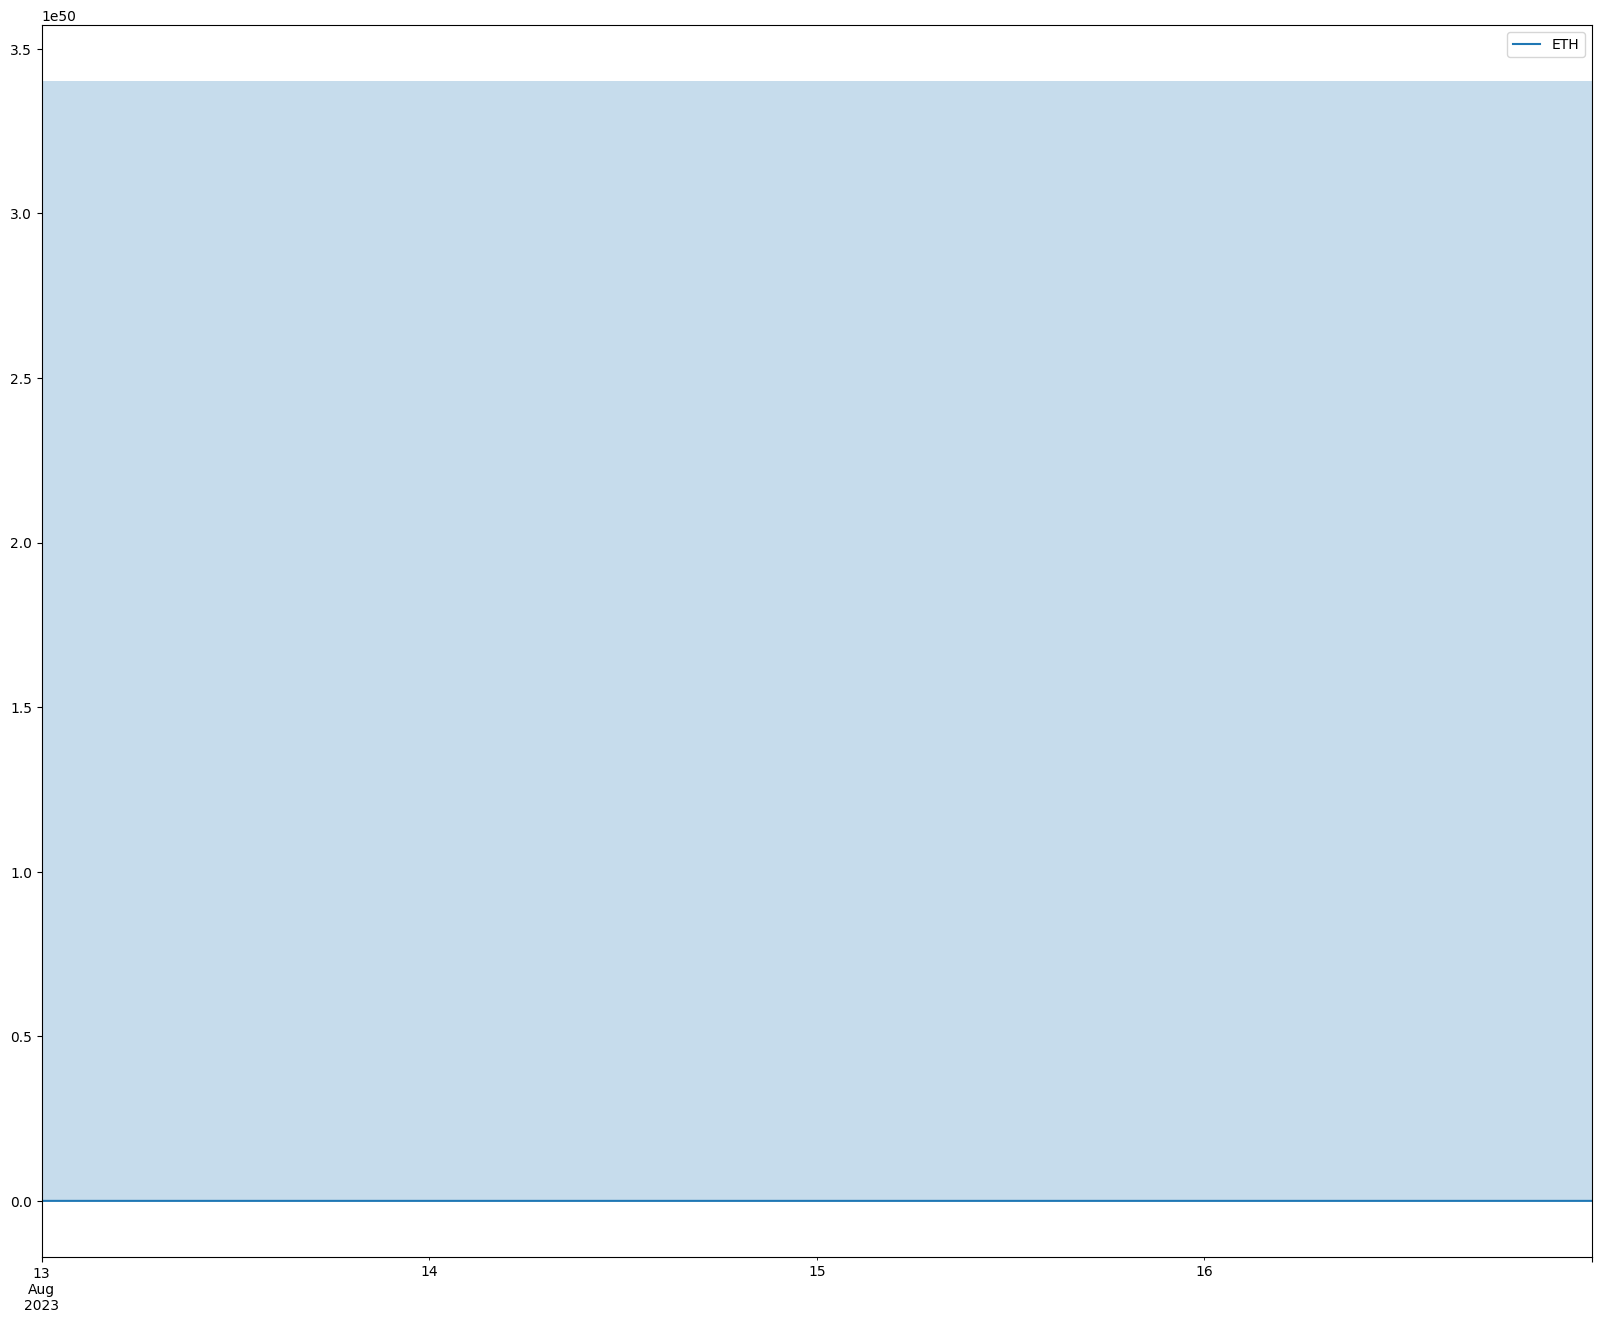

2024-07-22 17:46:18,880 - INFO - init strategy...
2024-07-22 17:46:18,882 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1908.95it/s]
2024-07-22 17:46:21,904 - INFO - main loop finished
2024-07-22 17:46:22,013 - INFO - Print actuator summary
2024-07-22 17:46:22,157 - INFO - Backtesting finished, execute time 3.278559923171997s
2024-07-22 17:46:22,221 - INFO - files have saved to ./result\backtest-20240722-174622.account.csv,./result\backtest-20240722-174622.action.json,./result\backtest-20240722-174622.action.pkl


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.0024326580             
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick      pending0         pending1       liquidity
0     -887272      887272    0.15974968    0.00010166386  41870380470367
1      199141      203540  0.0092985270  0.0000059175336   4874291990085

Account balance history                           
l1                  net_value tokens              uni_market                                                                                          price     
l2                              USDC          ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 3648.2861      0 0.0

C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


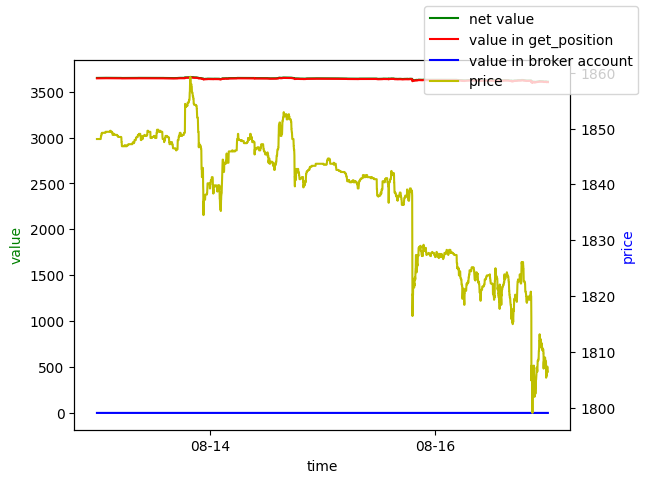

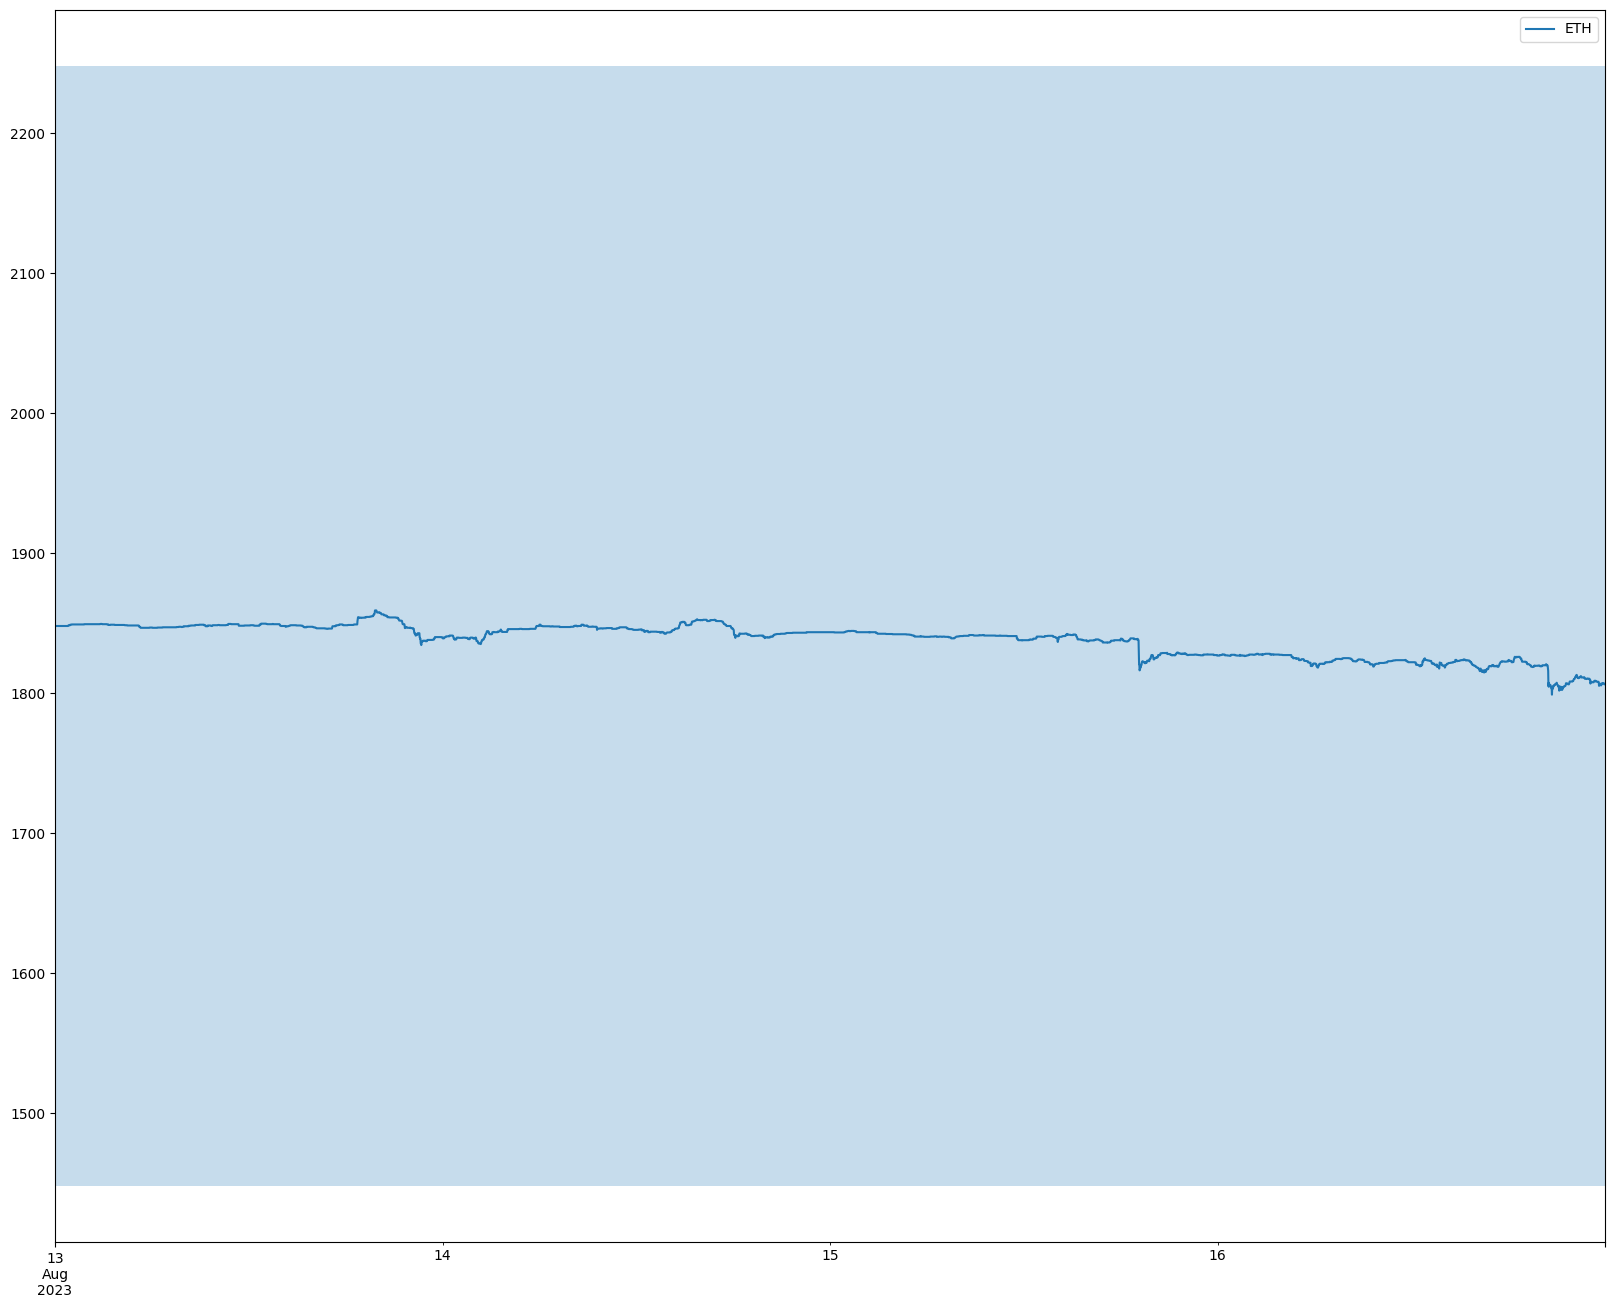

2024-07-22 17:46:22,944 - INFO - init strategy...
2024-07-22 17:46:22,947 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:02<00:00, 2390.84it/s]
2024-07-22 17:46:25,359 - INFO - main loop finished
2024-07-22 17:46:25,494 - INFO - Print actuator summary
2024-07-22 17:46:25,641 - INFO - Backtesting finished, execute time 2.697291135787964s
2024-07-22 17:46:25,708 - INFO - files have saved to ./result\backtest-20240722-174625.account.csv,./result\backtest-20240722-174625.action.json,./result\backtest-20240722-174625.action.pkl


Final account status                              
Token balance in broker       
USDC      :32.950706                ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1          liquidity
0      201161      201270  7.3950105  0.0048095466  15460776496730089

Account balance history                           
l1                  net_value    tokens              uni_market                                                                                          price     
l2                                 USDC          ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 3648.4802         0 0.0024326581  3643.9844    0.00010759182        0.16904821       0.984544

C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


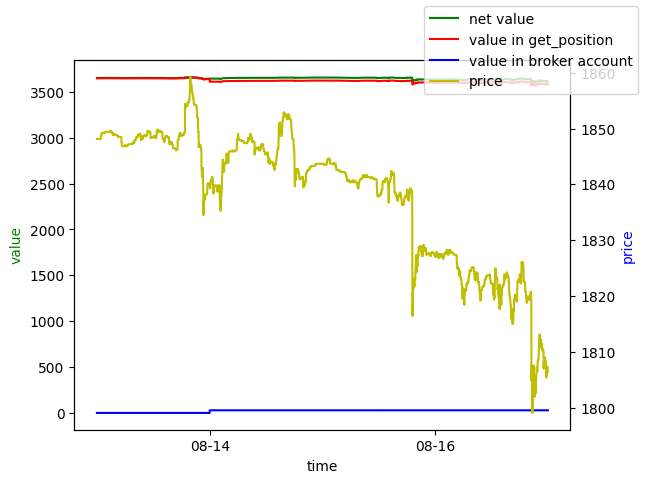

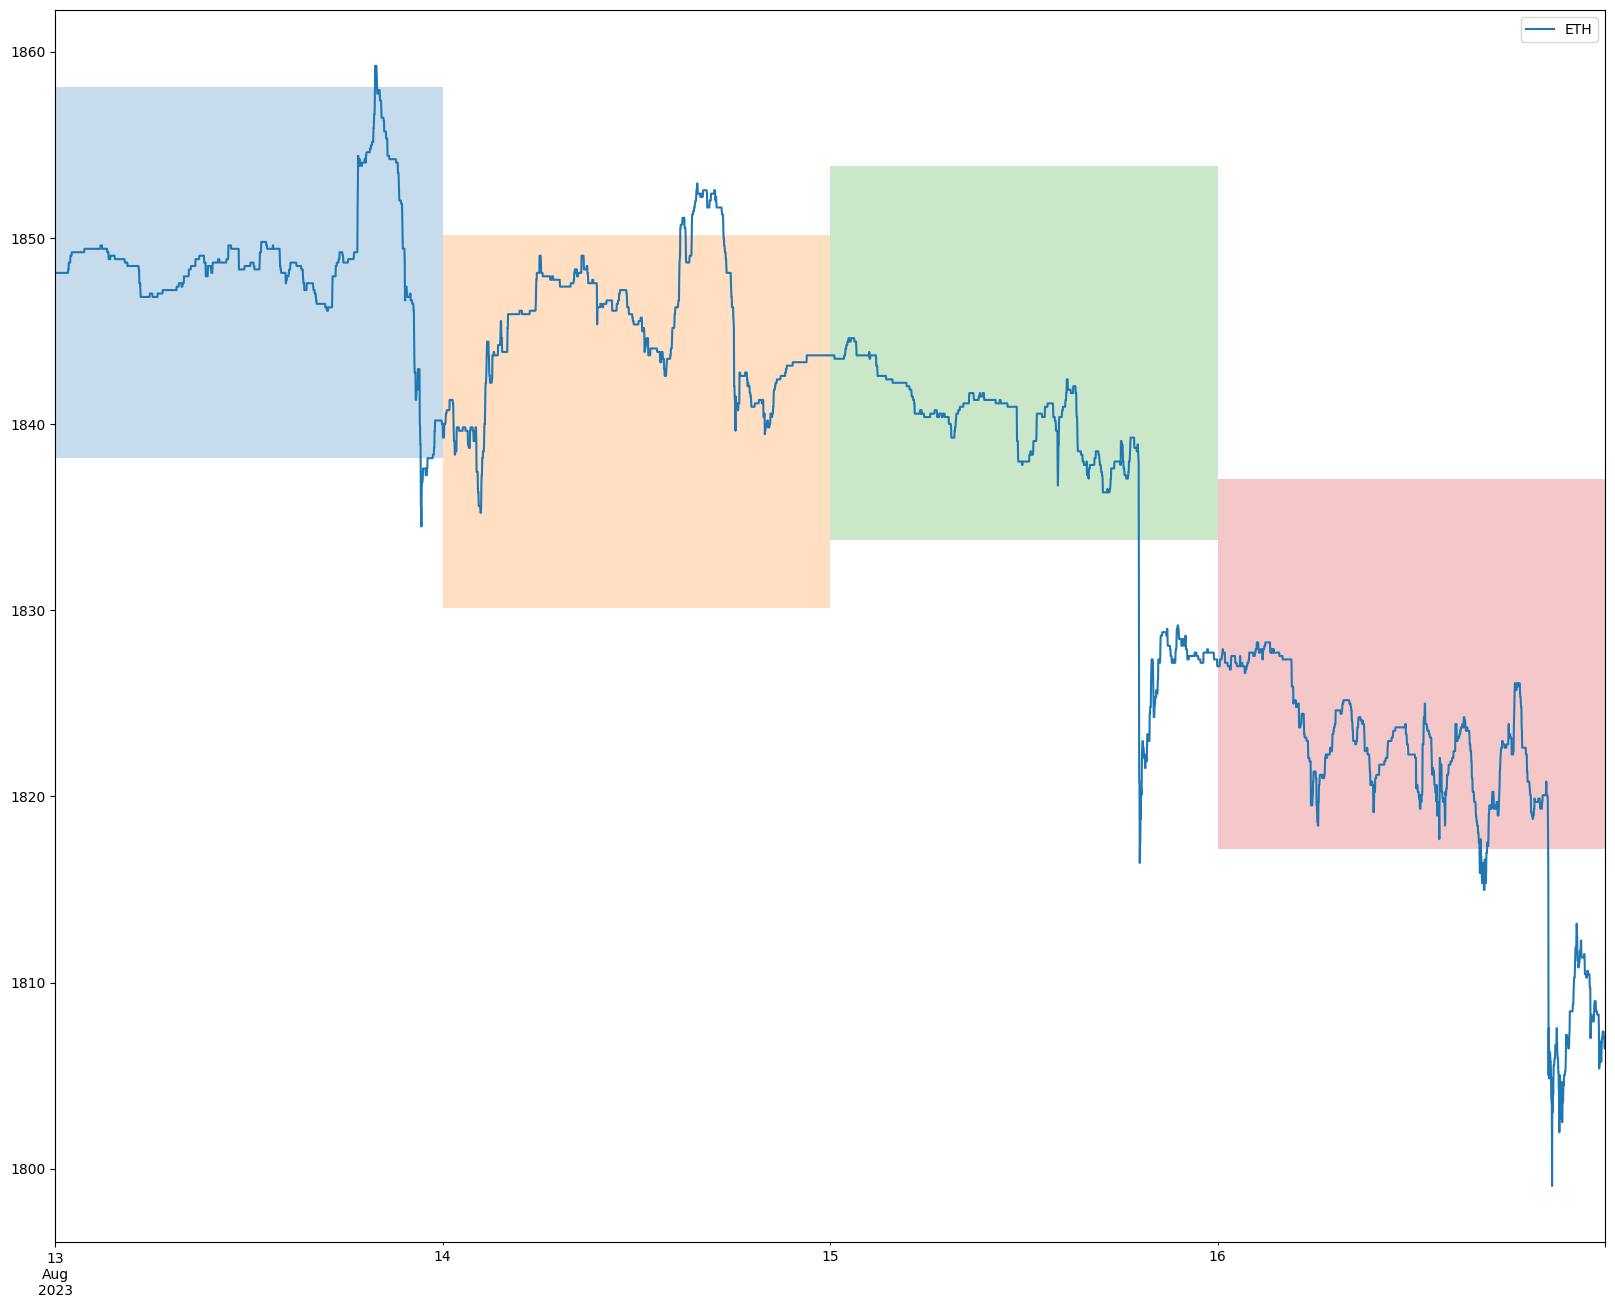

2024-07-22 17:46:26,746 - INFO - init strategy...
2024-07-22 17:46:26,750 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:02<00:00, 2814.60it/s]
2024-07-22 17:46:28,800 - INFO - main loop finished
2024-07-22 17:46:28,941 - INFO - Print actuator summary
2024-07-22 17:46:29,097 - INFO - Backtesting finished, execute time 2.35209059715271s
2024-07-22 17:46:29,172 - INFO - files have saved to ./result\backtest-20240722-174629.account.csv,./result\backtest-20240722-174629.action.json,./result\backtest-20240722-174629.action.pkl


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.99554508               
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick    pending0       pending1        liquidity
0      201216      202375  0.61938038  0.00040360235  755822864432331

Account balance history                           
l1                  net_value    tokens            uni_market                                                                                          price     
l2                                 USDC        ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 3650.7559 32.950706          0  3617.8052     0.0048095468         7.3950105                0    

C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


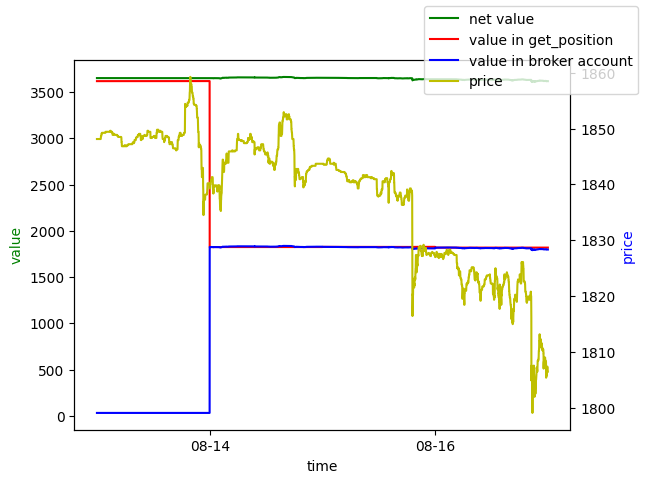

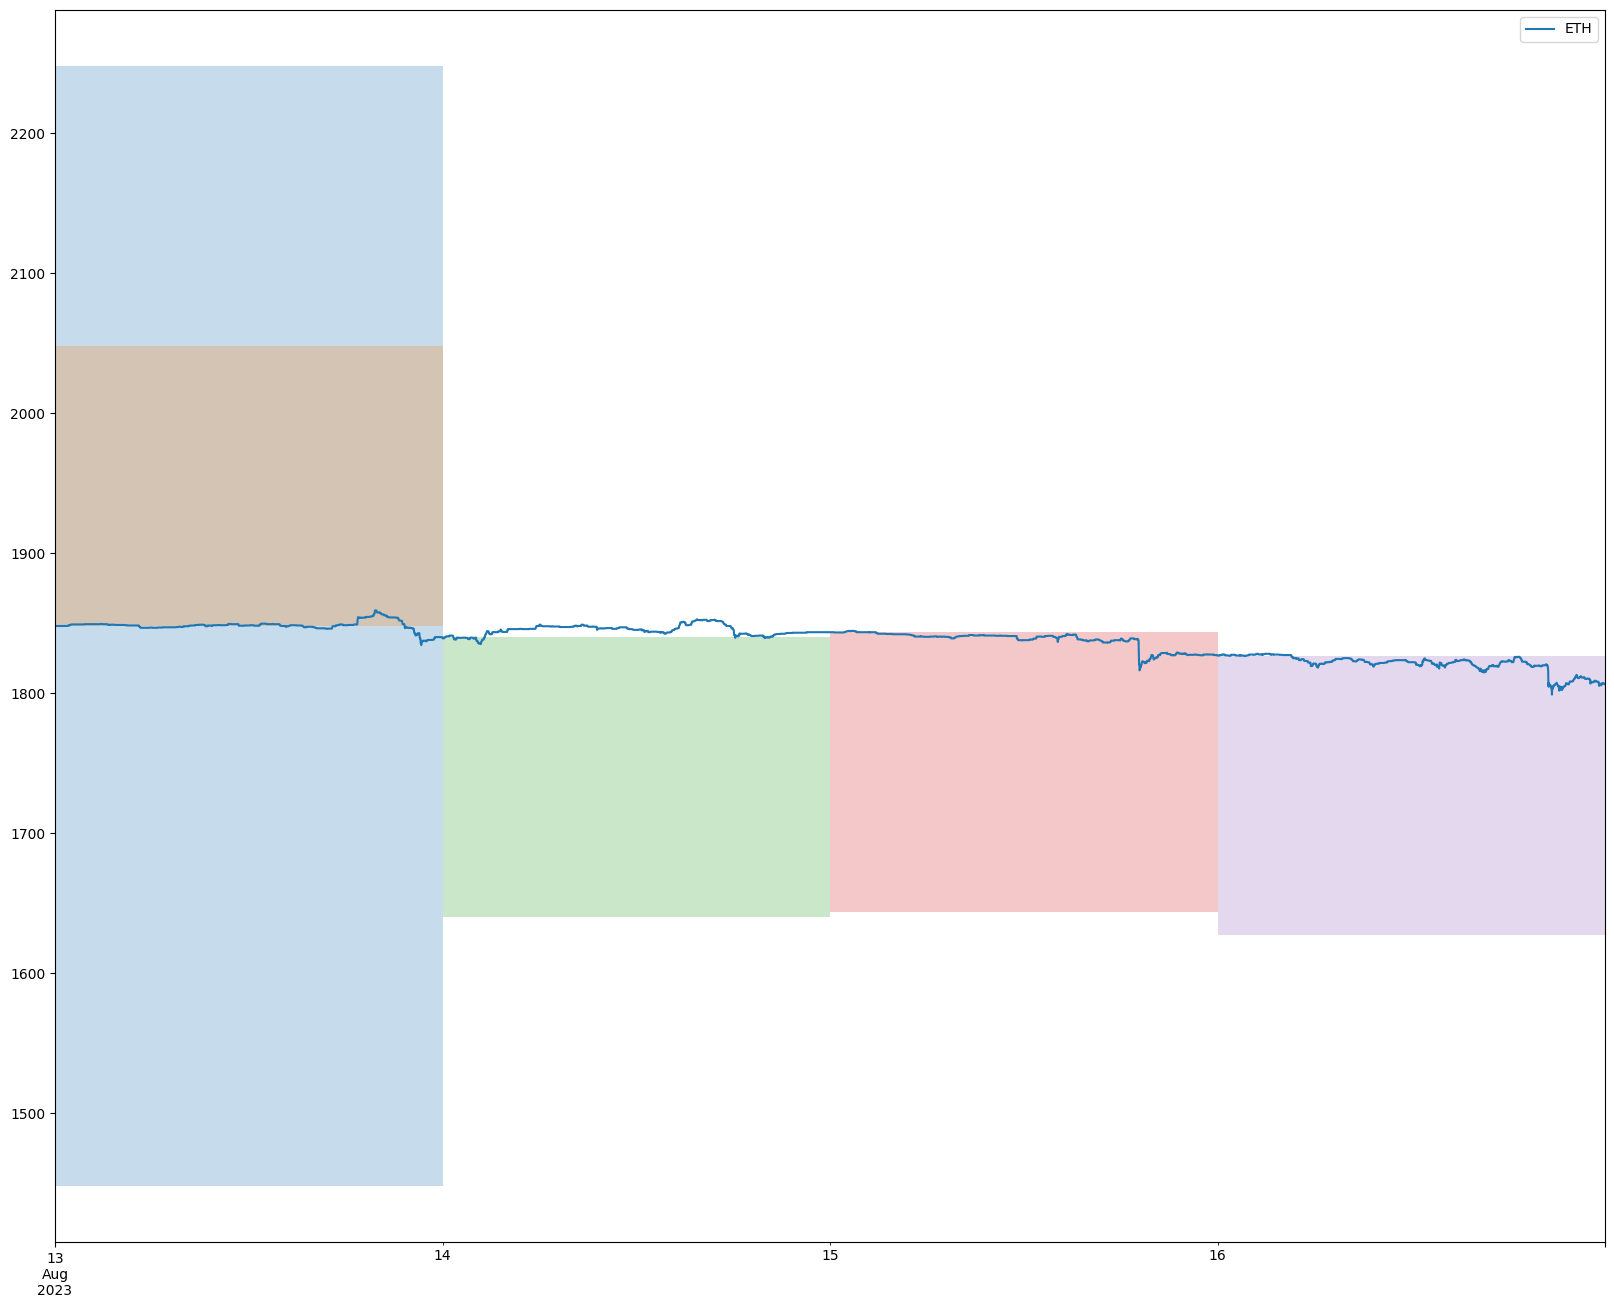

2024-07-22 17:46:29,979 - INFO - init strategy...
2024-07-22 17:46:29,982 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:02<00:00, 2056.75it/s]
2024-07-22 17:46:32,784 - INFO - main loop finished
2024-07-22 17:46:32,915 - INFO - Print actuator summary
2024-07-22 17:46:33,060 - INFO - Backtesting finished, execute time 3.0827488899230957s


Final account status                              
Token balance in broker       
USDC      :33.105541                ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1          liquidity
0      201161      201270  7.4295260  0.0048319874  15533426360814373
1      201161      201216      0e-10         0e-22                  0

Account balance history                           
l1                  net_value    tokens     uni_market                                                                                          price     
l2                                 USDC ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 3659.6543         0   0  3659.6543    0.0

2024-07-22 17:46:33,125 - INFO - files have saved to ./result\backtest-20240722-174633.account.csv,./result\backtest-20240722-174633.action.json,./result\backtest-20240722-174633.action.pkl
C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


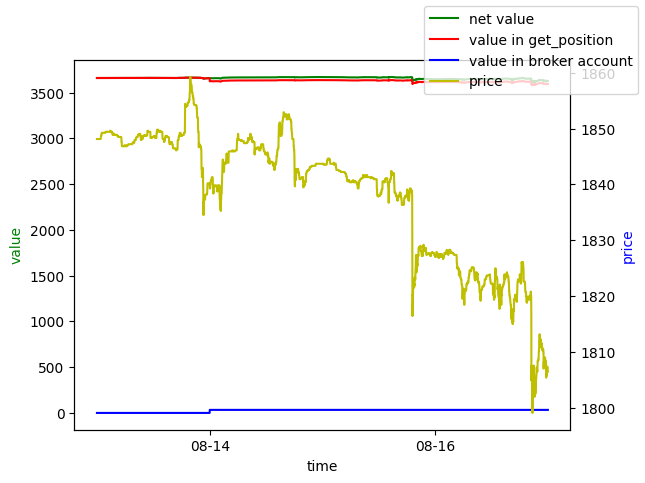

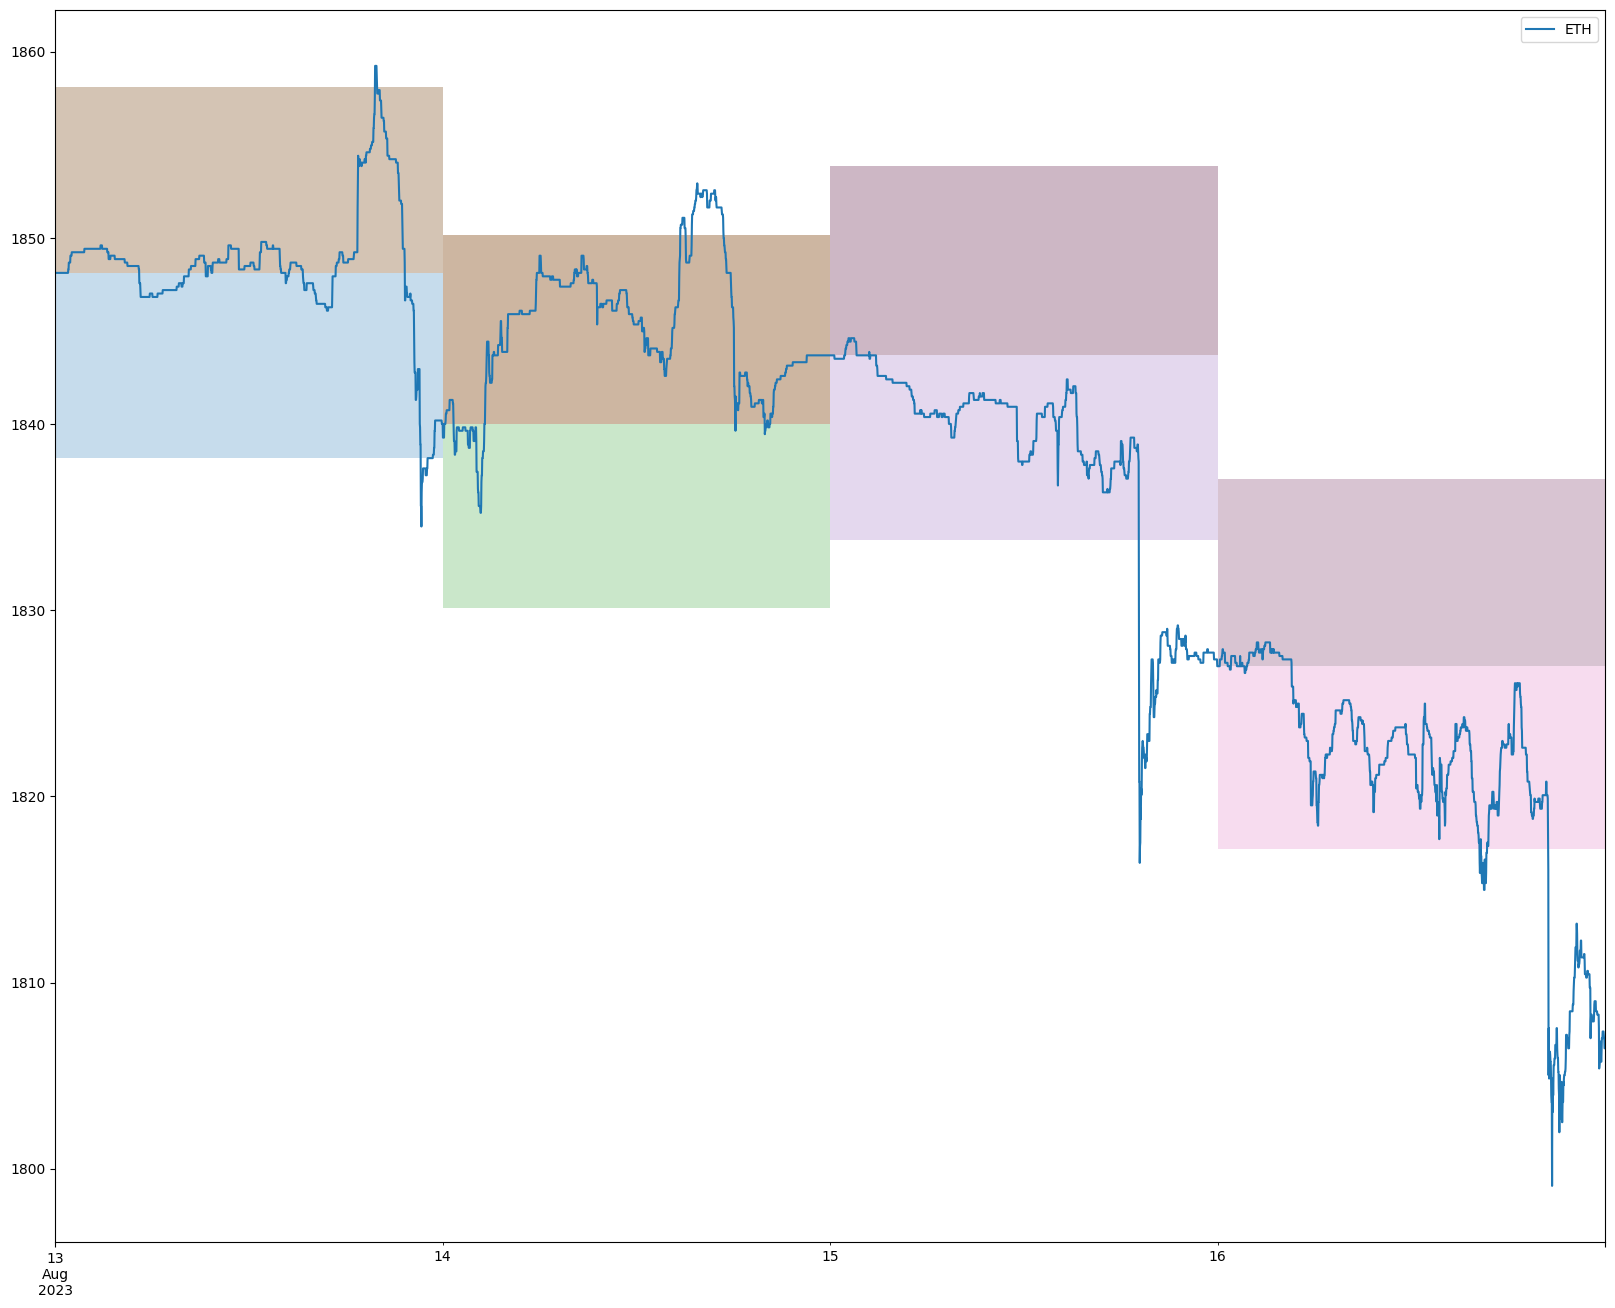

2024-07-22 17:46:34,005 - INFO - init strategy...
2024-07-22 17:46:34,014 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:02<00:00, 2312.24it/s]
2024-07-22 17:46:36,510 - INFO - main loop finished
2024-07-22 17:46:36,628 - INFO - Print actuator summary
2024-07-22 17:46:36,774 - INFO - Backtesting finished, execute time 2.770232915878296s


Final account status                              
Token balance in broker       
USDC      :9.7750797                ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick    pending0       pending1         liquidity
0      200709      201808  0.81702620  0.00052774407  1570613324425110

Account balance history                           
l1                  net_value    tokens             uni_market                                                                                          price     
l2                                 USDC         ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00  3666.998         0 0.051066864  3572.6201    3.4674053e-07                 0       0.9410194

2024-07-22 17:46:36,846 - INFO - files have saved to ./result\backtest-20240722-174636.account.csv,./result\backtest-20240722-174636.action.json,./result\backtest-20240722-174636.action.pkl
C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


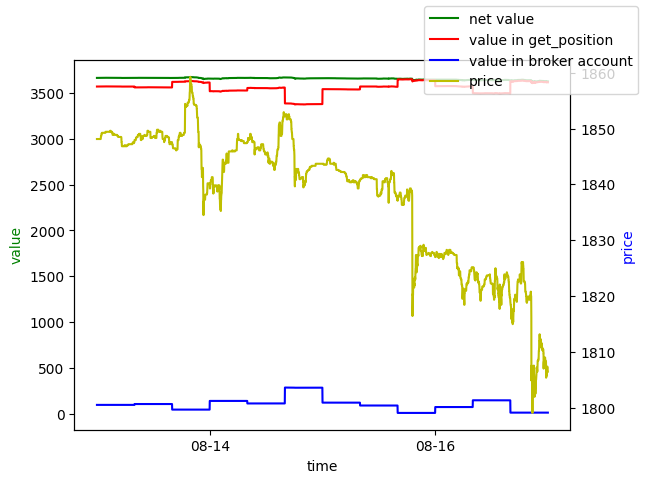

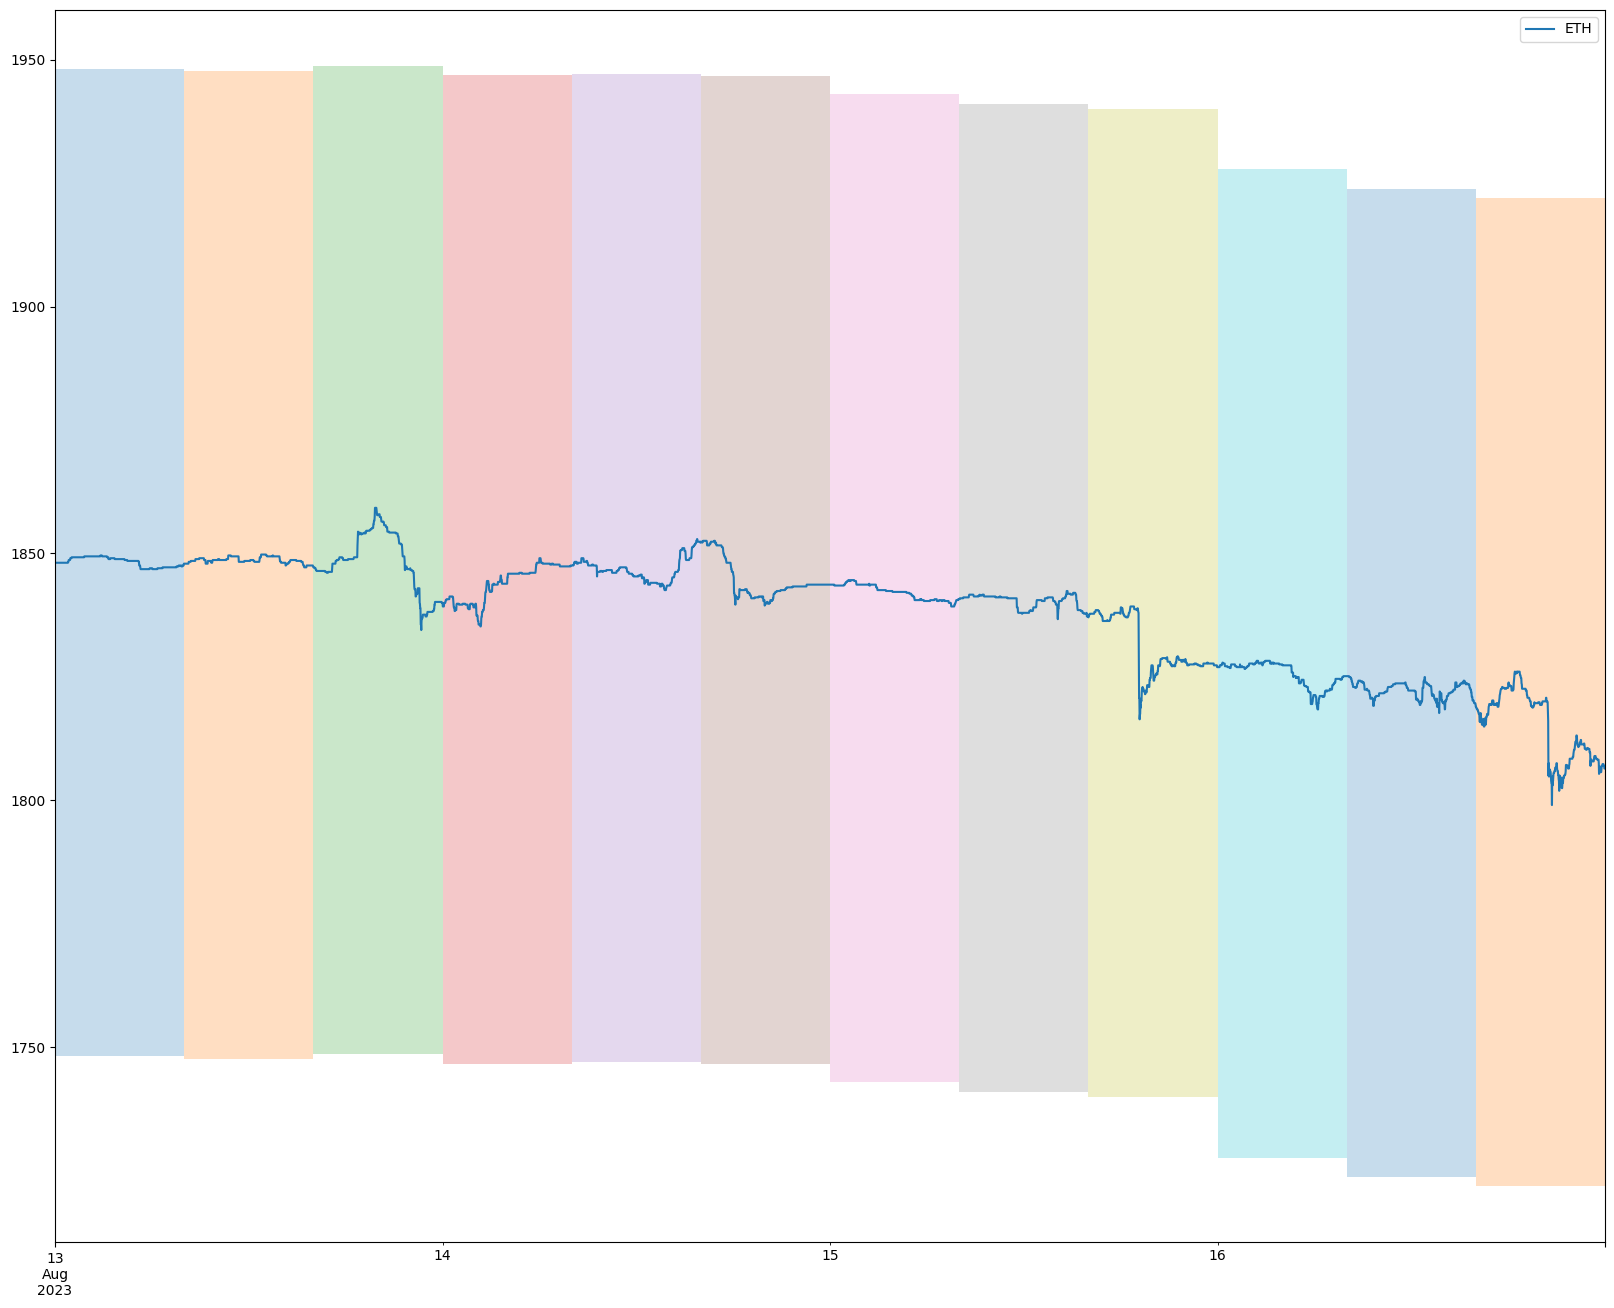

2024-07-22 17:46:37,632 - INFO - init strategy...
2024-07-22 17:46:37,701 - INFO - start main loop...
  0%|                                                                                                                        | 0/5760 [00:00<?, ?it/s]C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:279: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.markets.default.even_rebalance(self.data[market_key].price[0])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:01<00:00, 3187.57it/s]
2024-07-22 17:46:39,511 - INFO - main loop finished
2024-07-22 17:46:39,627 - INFO - Print actuator summary
2024-07-22 17:46:39,765 - INFO - Backtesting finished, execute time 2.1336729526519775s
2024-07-22 17:46:39,833 - INFO - 

Final account status                              
Token balance in broker       
USDC      :720.42912                ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick    pending0      pending1          liquidity
0      201215      201284  0.84610599  0.0014593316  19906118999554104

Account balance history                           
l1                  net_value    tokens           uni_market                                                                                          price     
l2                                 USDC       ETH  net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 3666.7913 1833.3956 0.9920305          0                0                 0                0     

C:\Users\sun\AppData\Local\Temp\ipykernel_17772\510123823.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


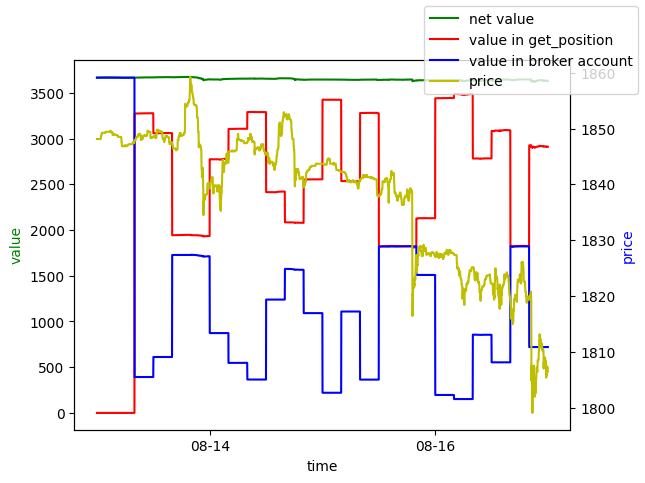

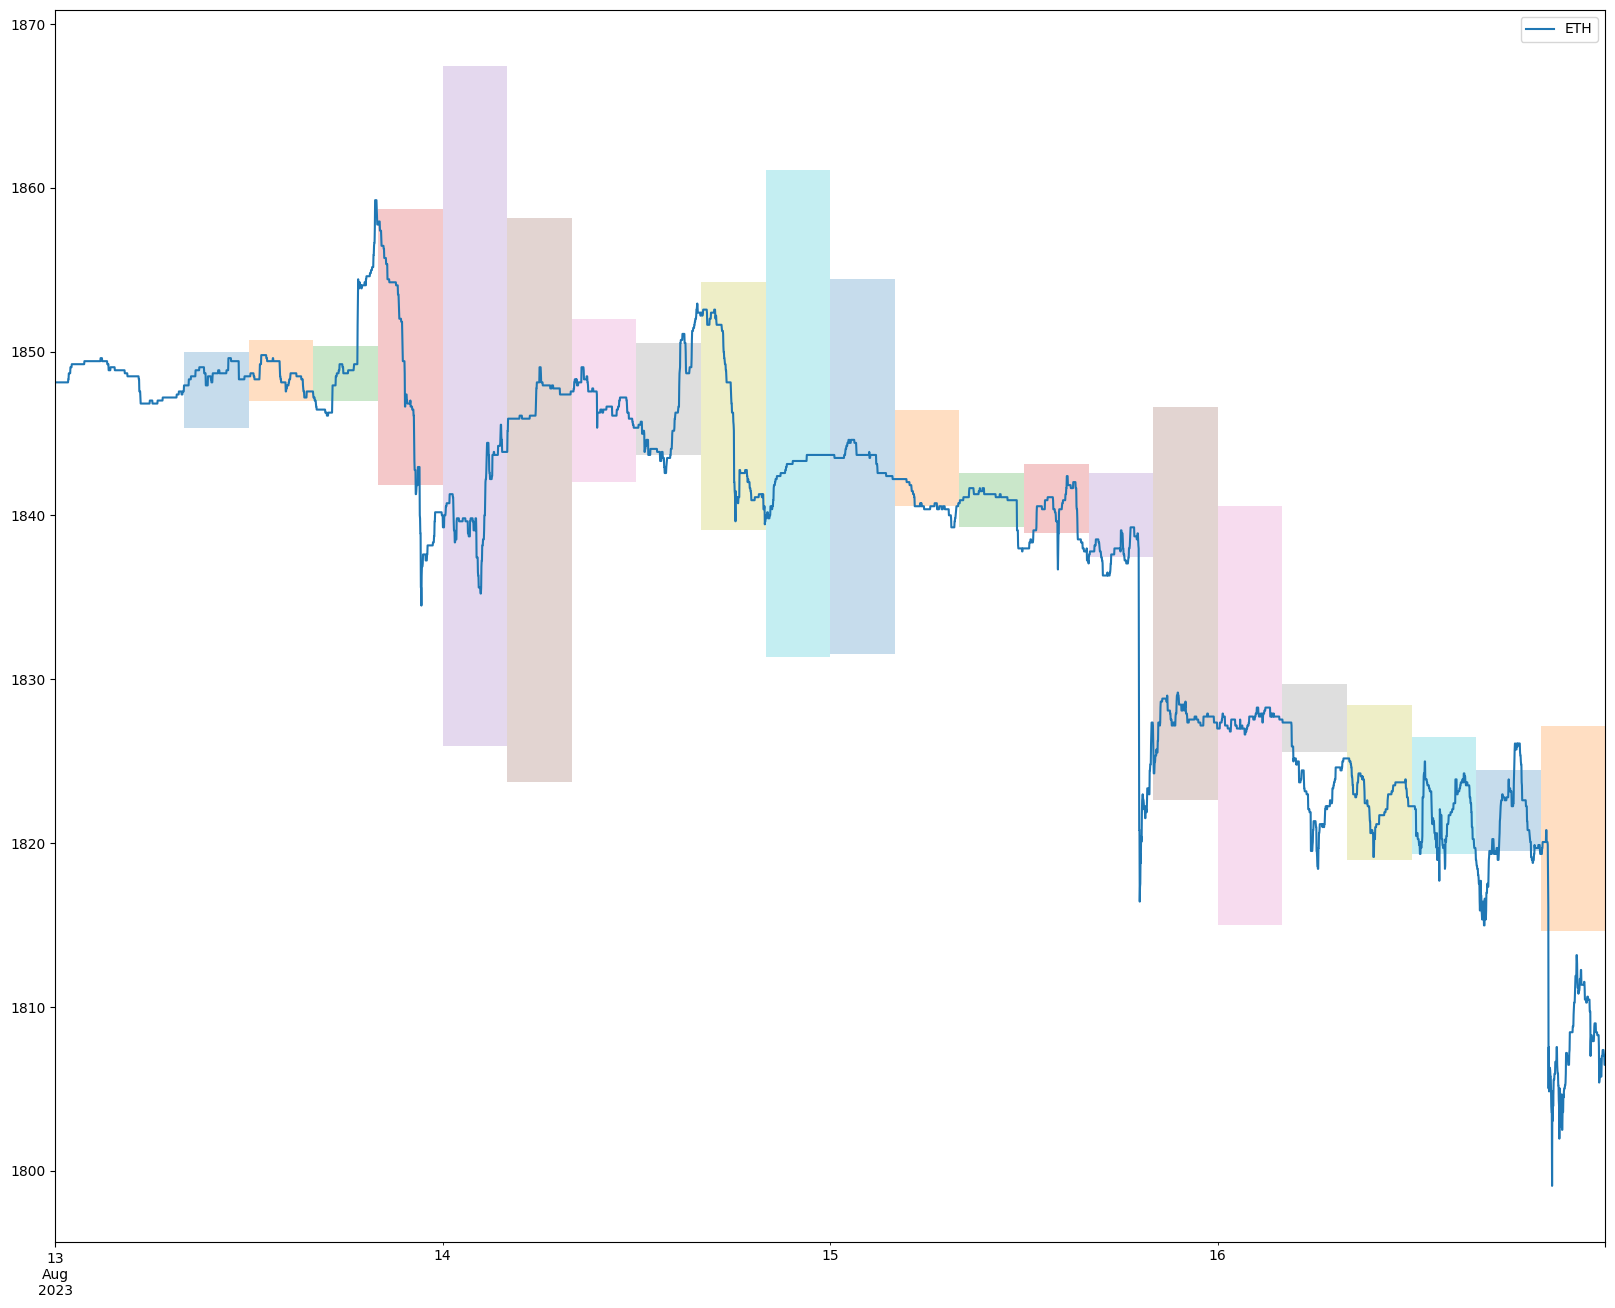

                                                 NoProvisionStrategy                                  UniswapV2Strategy                           ConstantIntervalStrategy             IntervalsAroundtheCurrentPriceStrategy          TwoIntervalsAroundtheCurrentPriceStrategy                                     FillUpStrategy                              MovingAverageStrategy                            BollingerBrandsStrategy
Return                 -41.65844214638536868733353912830352783203125      -41.71801409010231509455479681491851806640625       -41.1845473669591228826902806758880615234375          -38.5688607422125642187893390655517578125      -33.15989348585071638808585703372955322265625       -32.7804645835049086599610745906829833984375       -38.1810337920223901164717972278594970703125       -35.6937309585619004792533814907073974609375
Rate of Return     -0.0114191397641923986228107423812616616487503...  -0.0114354691817752929239304648945108056068420...  -0.011288738143173659977946

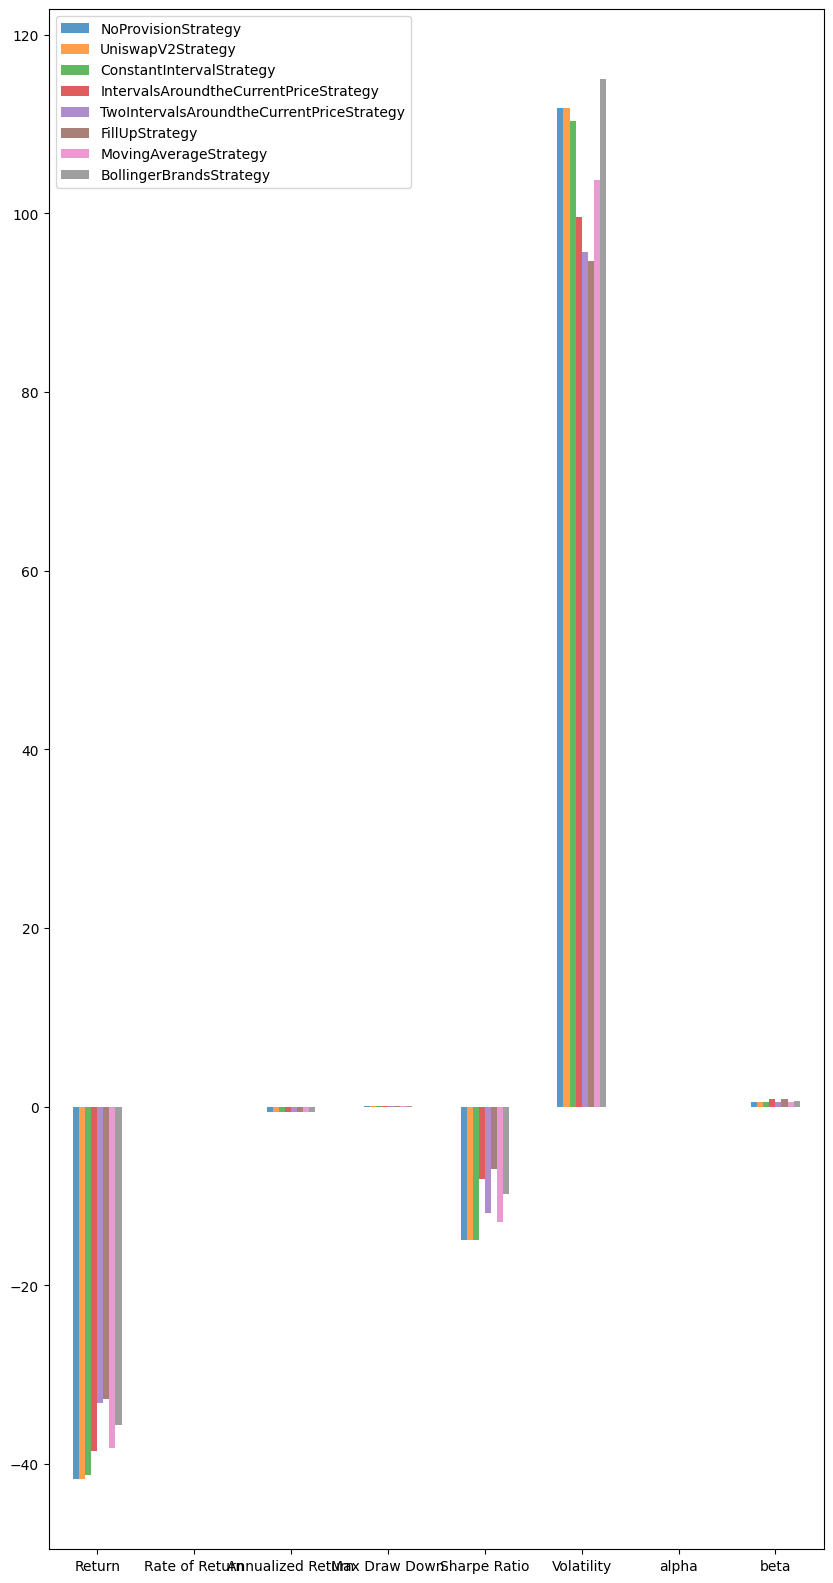

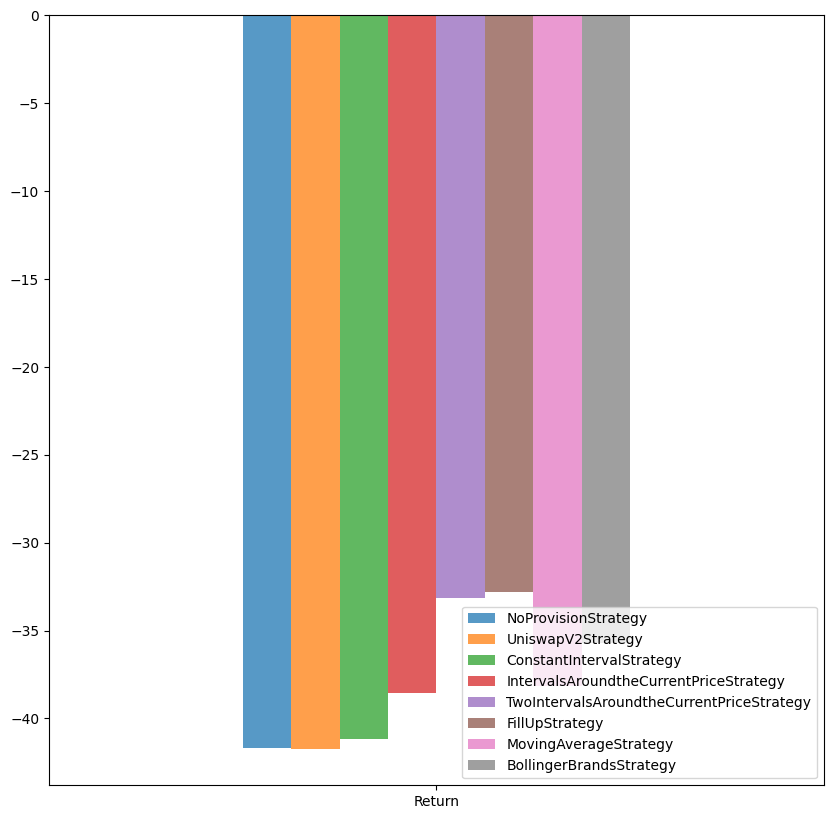

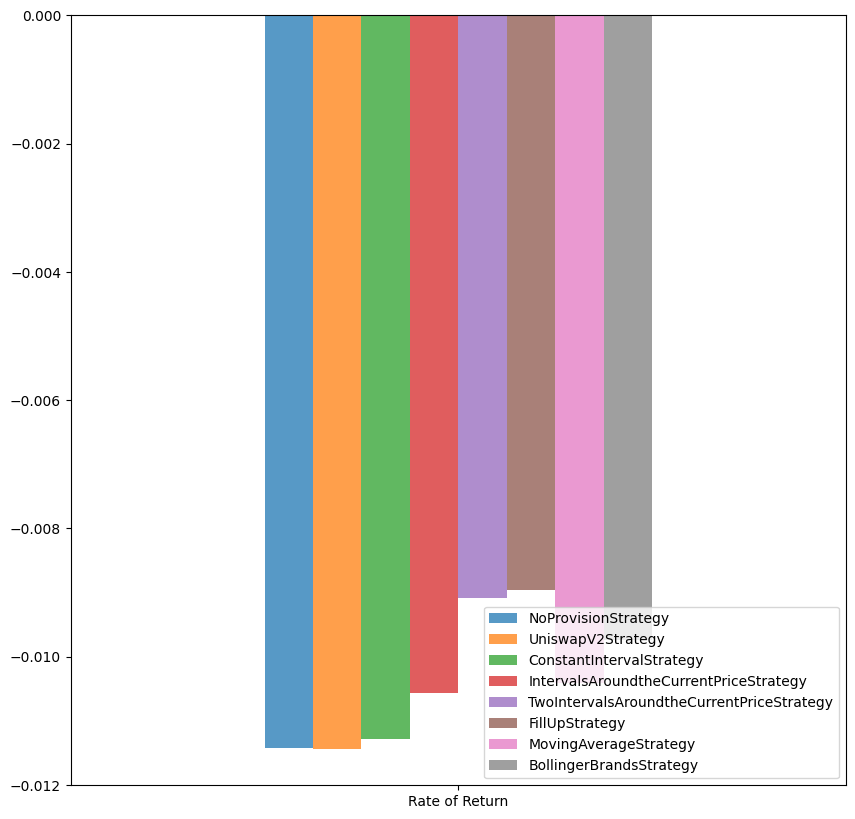

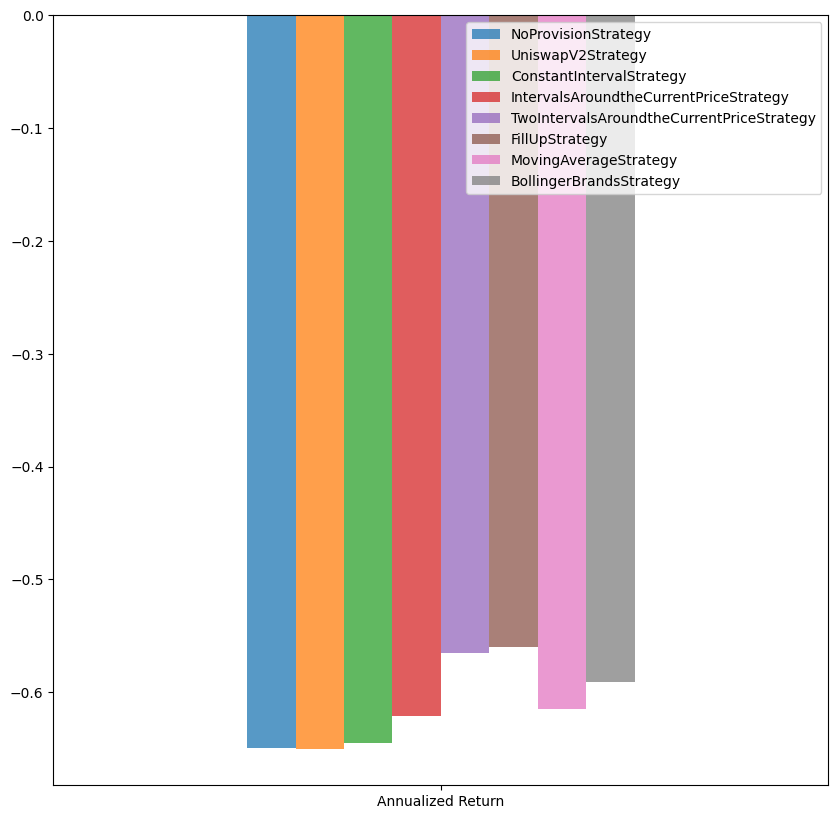

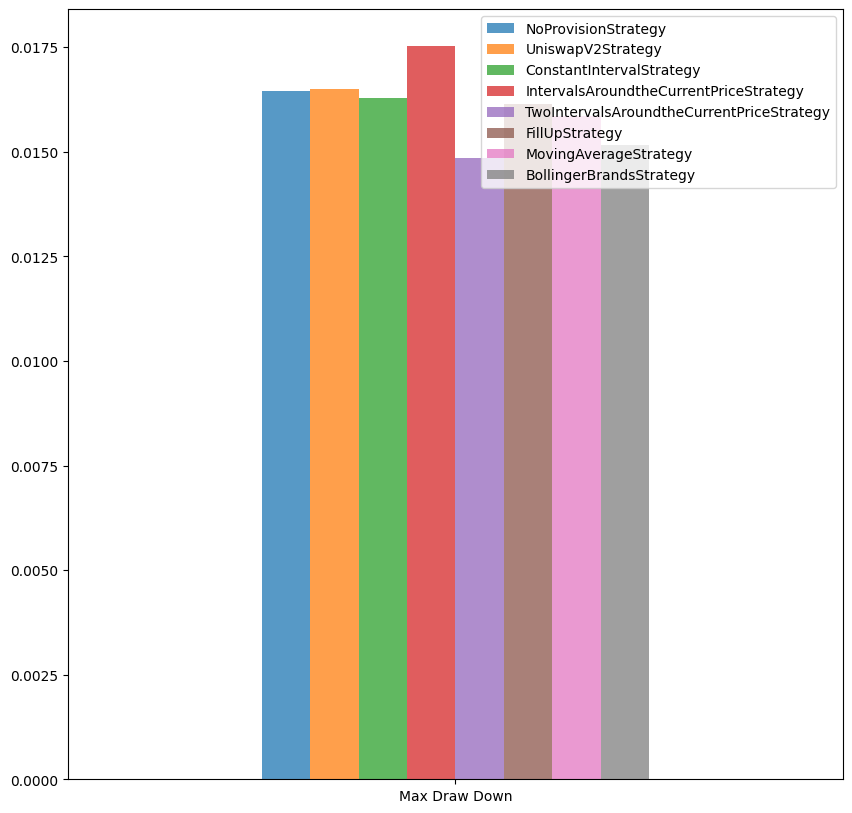

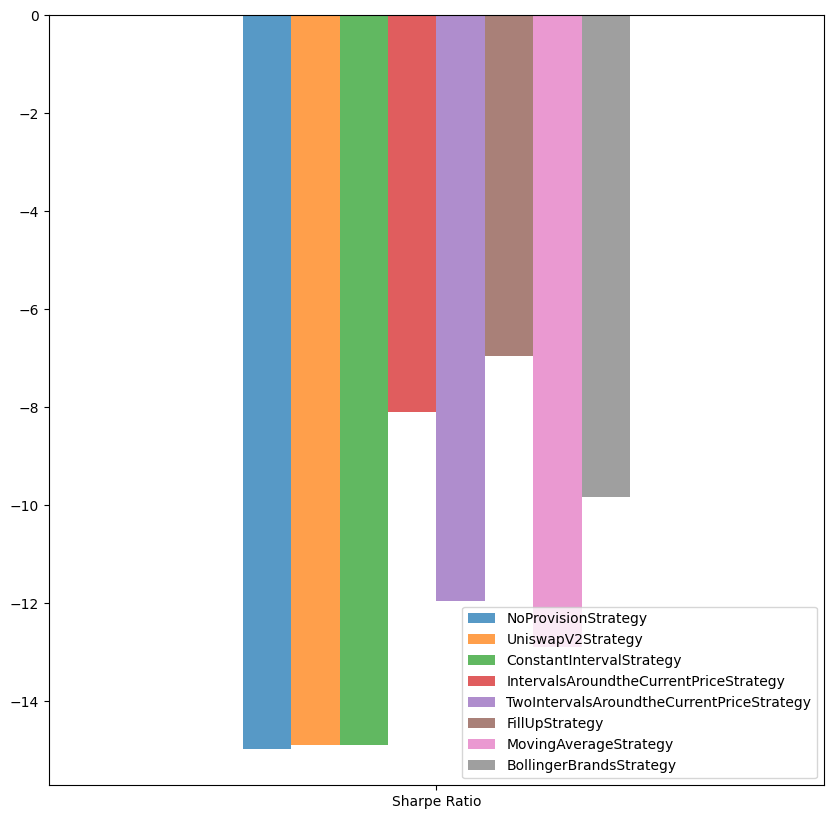

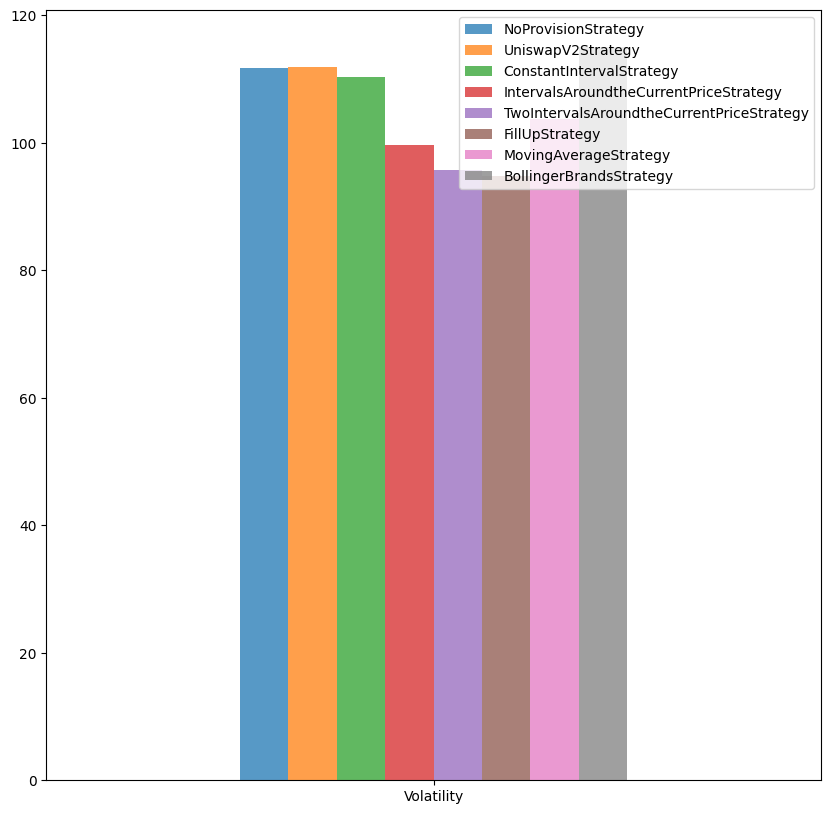

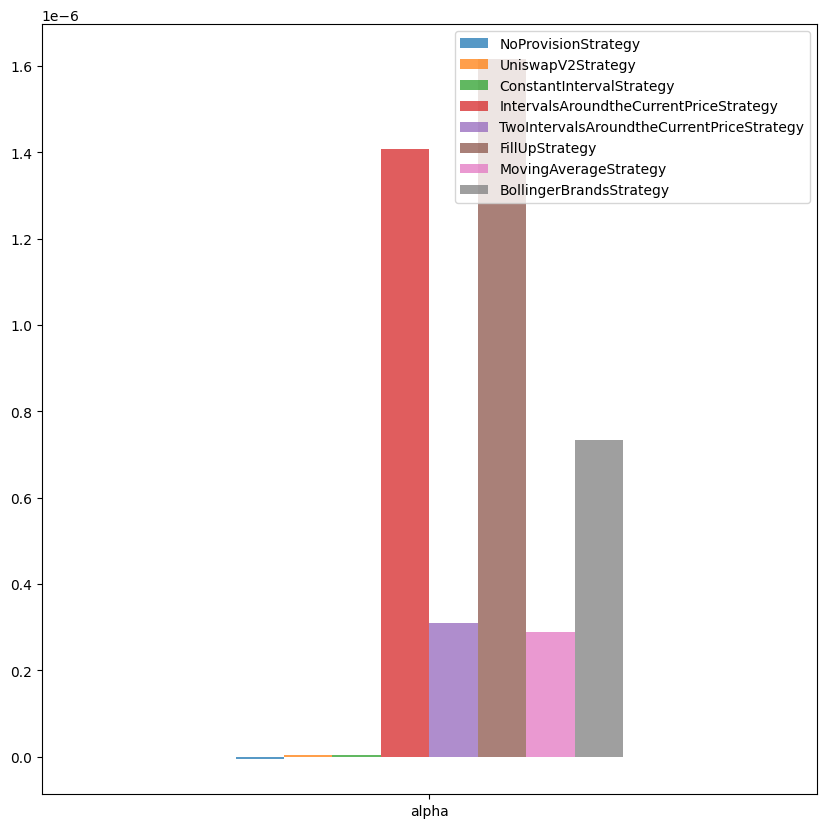

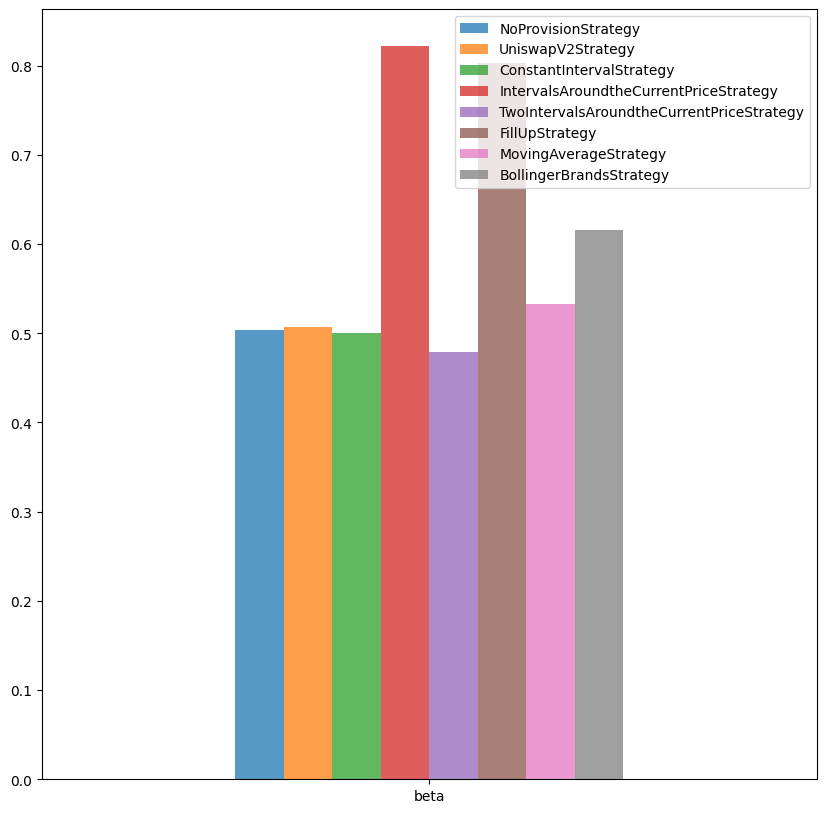

In [6]:
from demeter.result import performance_metrics
import math
from _decimal import Decimal
from datetime import date, datetime, timedelta
from typing import List

import matplotlib.dates as mdates
import pandas as pd
from matplotlib.pylab import plt

from demeter import TokenInfo, Actuator, Strategy, RowData, ChainType, MarketInfo, AtTimeTrigger, \
    PeriodTrigger, simple_moving_average, realized_volatility
from demeter.broker import AccountStatus, ActionTypeEnum
from demeter.uniswap import UniV3Pool, UniLpMarket
from demeter.uniswap.helper import tick_to_base_unit_price

pd.options.display.max_columns = None
pd.set_option("display.width", 5000)
c = 2


def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()


def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()


def calc_pair_price_by_sqrt(sqrt, decimal0=6, decimal1=18, base0=True):
    price = Decimal(sqrt) ** 2 / 2 ** 192 * Decimal(10 ** decimal0 - decimal1)
    return price if not base0 else 1 / price


def get_positions_info(actions, prices):
    positions = {}
    for action in actions:
        if action.action_type == ActionTypeEnum.uni_lp_add_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key not in positions:
                positions[key] = {'start': action.timestamp}
        if action.action_type == ActionTypeEnum.uni_lp_remove_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key in positions and action.remain_liquidity == 0:
                positions[key]['end'] = action.timestamp
    df_price = prices.copy(deep=True)
    df_price[eth.name] = df_price[eth.name].astype(float)
    df_price.plot(y=eth.name, kind='line', figsize=(20, 16))
    for key, position in positions.items():
        tick_lower, tick_upper = list(map(int, key.split('_')))
        price_upper = tick_to_base_unit_price(tick_lower, usdc.decimal, eth.decimal, market._is_token0_quote)
        price_lower = tick_to_base_unit_price(tick_upper, usdc.decimal, eth.decimal, market._is_token0_quote)
        if 'end' not in position:
            position['end'] = list(df_price.index)[-1]
        plt.fill_between([position['start'], position['end']], y1=price_lower, y2=price_upper, alpha=.25)
    plt.show()


class NoProvisionStrategy(Strategy):
    def initialize(self):
        """
        Initialize function will be called right before a backtest start.
        You can do various things here, e.g. register a trigger, or add a simple moving average line.
        """
        new_trigger = AtTimeTrigger(  # define a new trigger
            time=datetime(2022, 8, 20, 12, 0, 0), do=self.work  # we will make the action happen at 12:00 20/8/22
        )  # This is a callback function, defines what to do at this time.
        self.triggers.append(new_trigger)  # Register our trigger

    def work(self, row_data: RowData):
        """
        When time is up, work function will be called.
        """
        pass


class UniswapV2Strategy(Strategy):
    def initialize(self):
        """
        Initialize function will be called right before a backtest start.
        You can do various things here, e.g. register a trigger, or add a simple moving average line.
        """
        new_trigger = AtTimeTrigger(  # define a new trigger
            time=datetime(2023, 8, 13, 0, 0, 0), do=self.work
        )  # This is a callback function, defines what to do at this time.
        self.triggers.append(new_trigger)  # Register our trigger

    def work(self, row_data: RowData):
        """
        When time is up, work function will be called.
        """
        lp_market: UniLpMarket = self.markets[market_key]  # pick our market.
        lp_market.add_liquidity_by_tick(-887272, 887272)  # add liquidity
        pass


class ConstantIntervalStrategy(Strategy):
    def __init__(self, a=100):
        super().__init__()
        self.a = a

    def initialize(self):
        new_trigger = AtTimeTrigger(  # define a new trigger
            time=datetime(2023, 8, 13, 0, 0, 0), do=self.work
        )  # This is a callback function, defines what to do at this time.
        self.triggers.append(new_trigger)  # Register our trigger

    def work(self, row_data: RowData):
        """
        When time is up, work function will be called.
        """
        market: UniLpMarket = self.markets[market_key]
        init_price = market.market_status.data.price
        market.even_rebalance(init_price)  # rebalance all reserve token#
        market.add_liquidity(init_price - self.a, init_price + self.a)


class IntervalsAroundtheCurrentPriceStrategy(Strategy):
    def __init__(self, a=10, b=1, update_interval=timedelta(days=1)):
        super().__init__()
        self.a = a
        self.b = b

    def initialize(self):
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def init_work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        current_price = lp_market.market_status.data.price
        lp_market.add_liquidity(current_price - self.a, current_price + self.a)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        current_price = row_data.prices[eth.name]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])

        lp_market.add_liquidity(current_price - self.a, current_price + self.a)


class TwoIntervalsAroundtheCurrentPriceStrategy(Strategy):
    def __init__(self, a=10, b=1, update_interval=timedelta(days=1)):
        super().__init__()
        self.a = a
        self.b = b

    def initialize(self):
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def init_work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        init_price = lp_market.market_status.data.price

        lp_market.add_liquidity(init_price - self.a, init_price + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(init_price - self.b, init_price)
        else:
            lp_market.add_liquidity(init_price, init_price + self.b)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]

        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])

        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(row_data.prices[eth.name] - self.b, row_data.prices[eth.name])
        else:
            lp_market.add_liquidity(row_data.prices[eth.name],
                                    row_data.prices[eth.name] + row_data.prices[eth.name] + self.b)


class FillUpStrategy(Strategy):
    def __init__(self, a=10):
        super().__init__()
        self.a = a

    def initialize(self):
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def init_work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        init_price = lp_market.market_status.data.price

        lp_market.even_rebalance(init_price)  # rebalance all reserve token#
        lp_market.add_liquidity(init_price - self.a, init_price + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(init_price - self.a, init_price)
        else:
            lp_market.add_liquidity(init_price, init_price + self.a)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        lp_market.add_liquidity(row_data.prices[eth.name] - self.a, row_data.prices[eth.name] + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(row_data.prices[eth.name] - self.a, row_data.prices[eth.name])
        else:
            lp_market.add_liquidity(row_data.prices[eth.name], row_data.prices[eth.name] + self.a)


class MovingAverageStrategy(Strategy):

    def __init__(self, price_width=100):
        super().__init__()
        self.price_width = price_width

    def initialize(self):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        self.add_column(lp_market, "ma5", simple_moving_average(self.data.default.price, timedelta(hours=4)))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(hours=8), trigger_immediately=True, do=self.work))

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        ma_price = row_data.market_status.default.ma5 if row_data.market_status.default.ma5 > 0 else row_data.prices[
            eth.name]
        lp_market.add_liquidity(ma_price - self.price_width, ma_price + self.price_width)


class BollingerBrandsStrategy(Strategy):
    """
    We will provide liquidity inside the Bollinger Bands.
    These bands are made up of a lower band BOLL = pa − c · v
    and an upper band BOLU = pa + c · v.
    The liquidity get_position will be [pa − v · c, pa + v · c].

    * pa is simple moving average
    * c is a constant value, =2
    * v is volatility

    we will adjust liquidity every 4 hours, by remove all the liquidity, then even split all the capital into two assets,
    and provide liquidity by the rules above.

    """

    def initialize(self):
        self.add_column(market_key, "sma_1_day", simple_moving_average(self.data[market_key].price, timedelta(hours=4)))
        self.add_column(market_key, "volatility",
                        realized_volatility(self.data[market_key].price, timedelta(hours=4), timedelta(hours=4)))
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(hours=4), trigger_immediately=True, do=self.work))

    def init_work(self, row_data: RowData):
        self.markets.default.even_rebalance(self.data[market_key].price[0])

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        lp_row_data = row_data.market_status[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        if math.isnan(lp_row_data.volatility):
            return
        limit = c * float(row_data.prices[eth.name]) * lp_row_data.volatility
        lp_market.add_liquidity(lp_row_data.sma_1_day - limit, lp_row_data.sma_1_day + limit)


# Declare a token, and it's name will be used as unit of amounts.
usdc = TokenInfo(name="usdc", decimal=6)  # declare token usdc
eth = TokenInfo(name="eth", decimal=18)  # declare token eth
# Declare an Uniswap V3 pool. We will set the parameters according to the real pool on chain.
pool = UniV3Pool(token0=usdc, token1=eth, fee=0.05, quote_token=usdc)

# Declare a market key, which will be used to find the corresponding market in broker
market_key = MarketInfo("uni_market")
# Declare the market,
market = UniLpMarket(market_key, pool)  # uni_market:UniLpMarket, positions: 0, total liquidity: 0
# load data for market. those data is prepared by download tool
market.data_path = "../data"  # set data path
market.load_data(
    chain=ChainType.polygon.name,  # load data
    contract_addr="0x45dda9cb7c25131df268515131f647d726f50608",
    start_date=date(2023, 8, 13),
    end_date=date(2023, 8, 16),
)

# Declare the Actuator, which controls the whole process
actuator = Actuator()  # declare actuator, Demeter Actuator (broker:assets: ; markets: )
# add market to broker
actuator.broker.add_market(market)
# Initial some fund to broker.
actuator.broker.set_balance(usdc, 1800)
actuator.broker.set_balance(eth, 1)
# Set strategy to actuator
actuator.strategy = NoProvisionStrategy()  # set strategy to actuator
# Set price. Those price will be used in all markets.
# Usually, you will have to find the price list from outer source.
# Luckily, uniswap pool data contains price information. So UniLpMarket provides a function to retrieve price list.
actuator.set_price(market.get_price_from_data())
# run test, If you use default parameter, final fund status will be printed in console.

evaluating_results = []
pd_columns = []
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = UniswapV2Strategy()
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = ConstantIntervalStrategy(a=400)
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = IntervalsAroundtheCurrentPriceStrategy()
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = TwoIntervalsAroundtheCurrentPriceStrategy(400, 200)
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = FillUpStrategy()
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = MovingAverageStrategy()
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = BollingerBrandsStrategy()
actuator.run()
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
))
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

df = pd.DataFrame(evaluating_results)
df2 = df.T
df2.columns = pd_columns
print(df2)
for item in pd_columns:
    df2[item] = pd.to_numeric(df2[item])
df2.plot(kind='bar', alpha=0.75, rot=0, figsize=(10, 20))
plt.show()
for index in list(df2.index):
    df3 = df2[df2.index.isin([index])]
    df3.plot(kind='bar', alpha=0.75, rot=0, figsize=(10, 10))
    plt.show()